# Benchmark Pan 2014 para esse problema

resultados com micro-avg < 0.30  foram removidos

|Team                  |Dutch    |English    |Greek     |Spanish     |Micro-avg|Macro-avg|
|----------------------|--------:|----------:|---------:|-----------:|--------:|--------:|
|Bagnall               |0.451    |**0.614**  |**0.750** |0.721       |0.608    |0.628    |
|Bartoli et al.        |0.518    |0.323      |0.458     |**0.773**   |0.417    |0.506    |
|Moreau et al.         |**0.635**|0.453      |**0.693** |0.661       |0.534    |0.606    |
|Castro-Castro et al.  |0.247    |**0.520**  |0.391     |0.329       |0.427    |0.365    |
|Gómez-Adorno et al.   |0.390    |0.281      |0.348     |0.281       |0.308    |0.323    |
|Gutierrez et al.      |0.329    |0.513      |0.581     |0.509       |0.479    |0.478    |
|Halvani               |0.455    |0.458      |0.493     |0.441       |0.445    |0.462    |
|Hürlimann et al.      |0.616    |0.412      |0.599     |0.539       |0.487    |0.538    |
|Pacheco et al.        |0.624    |0.438      |0.517     |0.663       |0.480    |0.558    |
|PAN15-ENSEMBLE        |0.426    |0.468      |0.537     |0.715       |0.475    |0.532    |
|PAN14-BASELINE-1      |0.255    |0.249      |0.198     |0.443       |0.269    |0.280    |
|PAN14-BASELINE-2      |0.191    |0.409      |0.412     |0.683       |0.406    |0.405    |
|PAN13-BASELINE        |0.242    |0.404      |0.384     |0.367       |0.358    |0.347    |

## Bibliotecas

In [1]:
%matplotlib inline
#bibliotecas padrões do python
import os;
import codecs;
import re;
import sys;
import math;
import pickle;
from __future__ import print_function;

#bibliotecas científicas
import matplotlib.pyplot as plt;
import numpy as np; np.random.seed(42);
import pandas as pd;
import random;
import zipfile;
import json;

#bibliotecas para machine learning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer;

from sklearn.decomposition     import PCA;
from sklearn.pipeline          import Pipeline;
from sklearn.feature_selection import SelectPercentile,SelectFpr, f_classif, chi2;
from sklearn.model_selection   import StratifiedKFold,  GridSearchCV, train_test_split;
from sklearn.metrics           import f1_score, pairwise_distances,precision_recall_fscore_support, roc_auc_score, roc_curve;
from sklearn.metrics.pairwise  import paired_distances;
from sklearn.preprocessing     import RobustScaler, MaxAbsScaler, MinMaxScaler, normalize, minmax_scale;

from sklearn.linear_model      import LogisticRegression;

import scipy.spatial.distance as sdistance


import seaborn as sns;
import statsmodels.discrete.discrete_model as sm;

#bibliotecas customizadas.
from IPython.core.display import display, HTML, Markdown;

np.set_printoptions(precision=3);

# Funções utilitárias

In [2]:
def CNG_Keselj(matrixA, matrixB):
    """
    A profile-based method of particular interest, the Common n-Grams (CNG) approach, was described by Keselj, et al. (2003).
    -1 vetor A tem valores maiores
    0  A e B são iguais
    1  vetor B  tem valores maiores
    """
    matrixA = normalize(matrixA, norm='l1')
    matrixB = normalize(matrixB, norm='l1')
    dif   = (matrixA) - (matrixB);
    summ   = (matrixA) + (matrixB);
    
    s = (2 * dif /summ) **2;
    s = np.array(np.nanmean(s, axis=1)).flatten();    
    return s;

In [3]:
def CNG_Stamatatos(matrixA, matrixB):
    matrixA = normalize(matrixA, norm='l1')
    matrixB = normalize(matrixB, norm='l1')
    
    #difference to local
    s1 = (2 * (matrixA - matrixB) /(matrixA + matrixB)) **2;
    
    
    #global difference
    matrixCorpus = np.vstack((matrixA,matrixB));
    matrixCorpus =  normalize(np.sum(matrixCorpus,axis=0, keepdims=True), norm='l1');   
    s2 = (2 * (matrixA - matrixCorpus) /(matrixA + matrixCorpus)) **2;
    
    s = s1 * s2;    
    s = np.array(np.nanmean(s, axis=1)).flatten();    
    return s;

In [4]:
def cScore( Ypred, Y):
    """função definida segundo a competição pan.  A ideia é penalisar o classificador
    que retorna probabilidade de 50%, ou seja, não ser melhor que um chute aleatório """
    Ypred = np.round(Ypred,decimals=2);
    n  = len(Y)*1.0;
    nunansweard  = np.sum(Ypred == 0.5);
    
    ncorrect = np.sum( (Ypred>0.5) & (Y == 1) ) + np.sum( (Ypred<0.5) & (Y == 0) )    
    #ncorrect = np.sum(((Ypred>0.5) == Y)) - nunansweard;    
    return (1.0/n)*(ncorrect+(nunansweard*ncorrect/n));

In [5]:
def dist(ma, mb):
    return normalize(np.array(np.abs(ma - mb)),norm='l1');
    #return np.array(np.abs(ma - mb));
    
def difchi2(ma, mb):
    return np.log(1+(np.array(ma) - np.array(mb))**2 /(1+ np.array(ma)));


def kpi(pred, y):
    ks      = ksCurve(pred,y);
    roc     = rocCurve(pred,y);
    c_score = cScore  (pred,y);
    final   = roc * c_score;
    return ks, roc, c_score, final;


def kpi2(pred, y):
    roc     = rocCurve(pred,y);
    c_score = cScore  (pred,y);
    metrics =  {
        'ks':ksCurve(pred,y),
        'auc':roc,
        'C_score': c_score,
        'f1': f1_score(y, pred),
        'PAN' : roc * c_score
        
    };
    return metrics;

In [6]:
def densityBin(arr, bins=10, ma = 5):
    s, e= arr.min(), arr.max();
    r = (e-s)/bins;
    counts = np.zeros(bins +1);
    means  = np.zeros(bins +1);
    for i in arr:
        counts[int(math.floor((i-s)/r))]+=1
        means[int(math.floor((i-s)/r))]+=i
    means= means[counts!=0]/counts[counts!=0]
    counts= counts[counts!=0]
    for i in range(ma):
        counts[1:]+=counts[0:-1];
        counts[1:]/=2;
        counts[0:-1]+=counts[1:];
        counts[0:-1]/=2;
    return means, counts

In [7]:
def ks_binary(x,y, dtype=np.float32):
    notNAN= np.isnan(x)==False;
    y = y[notNAN];
    x = x[notNAN]; 
    
    argsorted = x.argsort();
    
    cdfFalse = (y[argsorted]==False).cumsum(dtype=dtype);
    cdfFalse /= cdfFalse[-1];

    cdfTrue = (y[argsorted]).cumsum(dtype=dtype);
    cdfTrue /= cdfTrue[-1];
    
    ks = np.abs(cdfFalse - cdfTrue).max();
    ks_mean = np.abs(cdfFalse - cdfTrue).mean();
    ks_stab = np.mean((cdfFalse - cdfTrue) >0);
    if ks_stab != 1 and ks_stab != 0:
        ks_entropy = - (ks_stab*np.log(ks_stab) + (1-ks_stab)*np.log(1-ks_stab));
    else:
        ks_entropy = 0;
    return ks, ks_entropy, ks_mean, argsorted, cdfFalse, cdfTrue;

In [8]:
def histKS(var, truth, cutoff=2.5,bins=30,colors=['#d7191c', '#2c7bb6'],alfa=0.5, labels=['False','True'], density=False):
    notNAN= np.isnan(var)==False;
    truth=truth[notNAN];
    var = var[notNAN];
    
    var = np.clip(var,a_min=np.percentile(var,cutoff), a_max=np.percentile(var,100-cutoff));
    plt.xlim((np.percentile(var,cutoff), np.percentile(var,100-cutoff)))
    plt.hist(var[truth == False], label=labels[0], bins=bins, color=colors[0], alpha=alfa);
    plt.hist(var[truth], label=labels[1], bins=bins,color=colors[1], alpha=alfa);
    
    ax2 = plt.twinx()
    
    ks, ks_entropy,ks_mean, argsorted, cdfFalse, cdfTrue = ks_binary(var, truth)
    ax2.plot(var[argsorted],cdfFalse,color=colors[0], label=labels[0])
    ax2.plot(var[argsorted],cdfTrue,color=colors[1], label=labels[1])
    ax2.set_ylim((0.0,1.05))

    plt.xlabel(u"Distância");
    plt.legend(loc='best')
    return ks, ks_entropy, ks_mean;


## Leitura dos datasets por tipo

In [9]:
def readFilesInstance(task, corpus):
            #pan14-author-verification-training-corpus-english-essays-2014-04-22
    base = 'pan14-author-verification-'+corpus+'-'+task+'-2014-04-22';
    
    problems = [];
    with zipfile.ZipFile(base+'.zip') as z:
        with z.open(base+'/truth.json') as fcontent:
            namelist = [name  for name in z.namelist()];
            content = json.load(fcontent);
            for problem in content['problems']:
                problemFolder = base+'/'+problem['name'];
                known = [];
                unknown = '';
                for name in namelist:
                    if problemFolder+'/known' in name:
                        with z.open(name) as f:
                            known.append(f.read());
                    elif problemFolder+'/unknown' in name:
                        with z.open(name) as f:
                            unknown += f.read();
                for i,n in enumerate(known):
                    p = problem.copy();
                    p['known'] = n;
                    p['unknown'] = unknown;
                    p['corpus'] = corpus;
                    p['name'] += "_"+str(i);
                    problems.append(p);
                #profile
                #p = problem.copy();
                #p['known'] = '\n'.join(known);
                #p['unknown'] = unknown;
                #p['corpus'] = corpus;
                #p['name'] += "_p";
                
                #problems.append(p);
    return problems;

In [10]:
def readFilesProfile(task, corpus):
            #pan14-author-verification-training-corpus-english-essays-2014-04-22
    base = 'pan14-author-verification-'+corpus+'-'+task+'-2014-04-22';
    
    problems = [];
    with zipfile.ZipFile(base+'.zip') as z:
        with z.open(base+'/truth.json') as fcontent:
            namelist = [name  for name in z.namelist()];
            content = json.load(fcontent);
            for problem in content['problems']:
                problemFolder = base+'/'+problem['name'];
                sys.stdout.flush()
                print("\rReading: %s"%(problemFolder), end=""),
                sys.stdout.flush()
                known = '';
                unknown = '';
                for name in namelist:
                    if problemFolder+'/known' in name:
                        with z.open(name) as f:
                            known += f.read();
                    elif problemFolder+'/unknown' in name:
                        with z.open(name) as f:
                            unknown += f.read();
                problem['known'] = known;
                problem['unknown'] = unknown;
                problem['corpus'] = corpus;
                problems.append(problem);
    return problems;

# Análise exploratória da base

In [11]:
#tasks = ['dutch-essays', 'dutch-reviews','english-essays','english-novels', 'greek-articles', 'spanish-articles'];
tasks = ['dutch-essays', 'dutch-reviews']
#tasks = ['greek-articles'];
#tasks = ['english-essays','english-novels']
corpus = ['training-corpus','test-corpus1','test-corpus2']
dataset = [
        pd.DataFrame(readFilesProfile(t,c))
            for t in tasks
                for c in corpus
        ]
dataset = pd.concat(dataset);

dataset.head(6)

Reading: pan14-author-verification-test-corpus2-dutch-reviews-2014-04-22/DR200

,answer,corpus,genre,known,language,name,unknown
0,Y,training-corpus,essays,"﻿Je ziet dat ze hun krant dubbelvouwen , probe...",dutch,DE001,﻿Dankzij het internet zijn we een grote bron a...
1,Y,training-corpus,essays,﻿Reclameboodschappen verknallen ons kijkplezie...,dutch,DE002,﻿Het is dus begrijpelijk dat de commerciële ze...
2,N,training-corpus,essays,﻿Spelers worden verkocht en gekocht aan immens...,dutch,DE003,"﻿"" Hey , vuile nicht ! Hangt er nog stront aan..."
3,N,training-corpus,essays,﻿Een meter is geen meter . Een minister wil ...,dutch,DE004,﻿Gelijkheid tussen man en vrouw is iets dat on...
4,N,training-corpus,essays,﻿De reclamecampagne bewijst weer eens dat de o...,dutch,DE005,﻿Gisteren was er opnieuw een protest tegen hom...
5,N,training-corpus,essays,﻿Volgens auteur Matthias Verstraete zijn spons...,dutch,DE006,﻿Voetbal is vandaag de dag zonder twijfel de p...


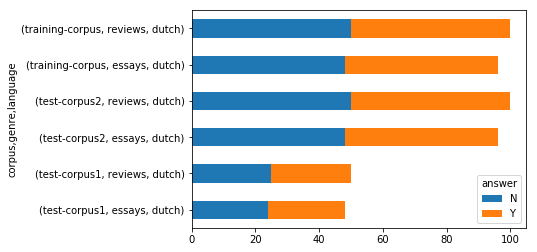

In [12]:
dataset\
.pivot_table(values='name',index=['corpus','genre','language'],columns='answer',aggfunc='count') \
.plot.barh(stacked=True);

## Filtrando as instancias de problemas que serão tratadas

Foi utilizado apenas o corpus de trainamento porque os corpus de teste estariam disponíveis apenas para o avaliadores.

In [13]:
datasetEstudo = dataset[ (dataset.corpus == 'training-corpus') ];
datasetEstudo = datasetEstudo[['name','language','genre','known','unknown','answer']];
datasetEstudo.head()

,name,language,genre,known,unknown,answer
0,DE001,dutch,essays,"﻿Je ziet dat ze hun krant dubbelvouwen , probe...",﻿Dankzij het internet zijn we een grote bron a...,Y
1,DE002,dutch,essays,﻿Reclameboodschappen verknallen ons kijkplezie...,﻿Het is dus begrijpelijk dat de commerciële ze...,Y
2,DE003,dutch,essays,﻿Spelers worden verkocht en gekocht aan immens...,"﻿"" Hey , vuile nicht ! Hangt er nog stront aan...",N
3,DE004,dutch,essays,﻿Een meter is geen meter . Een minister wil ...,﻿Gelijkheid tussen man en vrouw is iets dat on...,N
4,DE005,dutch,essays,﻿De reclamecampagne bewijst weer eens dat de o...,﻿Gisteren was er opnieuw een protest tegen hom...,N


In [14]:
datasetTest= dataset[ (dataset.corpus == 'test-corpus1') ];
datasetTest = datasetTest[['name','language','genre','known','unknown','answer']];
datasetTest.head()

,name,language,genre,known,unknown,answer
0,DE097,dutch,essays,De hele wereld kreunt onder de economische cri...,﻿Om een licentie te krijgen voor deelname aan ...,Y
1,DE098,dutch,essays,﻿Er kan vanalles mis gaan met de bezorging waa...,﻿De mens is de laatste tijd continu informatie...,Y
2,DE099,dutch,essays,﻿Deze morgen in de krant stond er weer een art...,﻿Dat beperkt de vrije mening . Homohaat zou na...,Y
3,DE100,dutch,essays,﻿Dingen leren of jezelf vormen : wat zou de be...,﻿Inleiding “Studenten scoren slecht in spellin...,Y
4,DE101,dutch,essays,﻿Westerlingen hebben jarenlang voor godsdienst...,﻿Dat op zich maakt het al een uitgesproken gro...,N


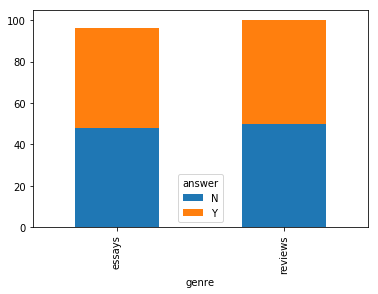

In [15]:
datasetEstudo.pivot_table(
    values='name',
    index=['genre'],
    columns='answer',aggfunc='count').plot.bar(stacked=True);

# analisando char n-grams  mais frequentes
Segundo a literatura (survery do stamatatos) o termos mais frequentes permitem diferenciar o autor sem ser impactados pelo contexto.
Estudando apontam também que entre 2 e 5 char n-grams apresentaram os melhores resultados.
Utilizando o TfidfVectorizer  sem a componente IDF porque ela faz pouco efeito e para utilizar a versão com 1+log(TF)

In [16]:
counter = CountVectorizer(
        analyzer="char",
        min_df=0.05,
        max_df=1.0,
        ngram_range=(2,5),
        lowercase=False,
        dtype=np.float64
    );

In [17]:
counter.fit(datasetEstudo.known.values);
ma = counter.transform(datasetEstudo.known.values).todense();
mb = counter.transform(datasetEstudo.unknown.values).todense();
maTest = counter.transform(datasetTest.known.values).todense();
mbTest = counter.transform(datasetTest.unknown.values).todense();
ngrams = np.array([len(c) for c in counter.get_feature_names()])

In [18]:
dfText = np.array(np.mean(ma >0,axis=0)).flatten()

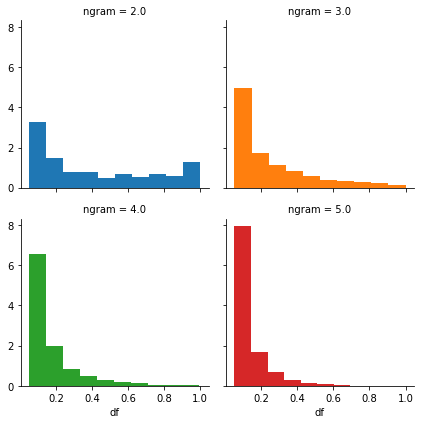

In [67]:

grid = sns.FacetGrid(
    pd.DataFrame(np.c_[dfText, ngrams], columns=['df','ngram']), col="ngram", hue='ngram', col_wrap=2, size=3)
grid.map(plt.hist, "df", density=True)
grid.fig.tight_layout(w_pad=1)

In [20]:
tfidf = TfidfTransformer(norm='l1',smooth_idf=True, sublinear_tf=True, use_idf=True)

In [21]:
known      = tfidf.fit_transform(ma[:,dfText>0]).todense();
unknown    = tfidf.transform(mb    [:,dfText>0]).todense();
knownTest  = tfidf.transform(maTest[:,dfText>0]).todense();
unknownTest= tfidf.transform(mbTest[:,dfText>0]).todense();

In [22]:
def fuzzyyulef(u, v, w=None):
    nff = np.minimum(u,v).sum();
    ntf = u[u < v].sum();
    nft = v[v < u].sum();
    ntt = np.maximum(u,v).sum();
    return float(2.0 * ntf * nft / np.array(ntt * nff + ntf * nft))

In [23]:
def ksDistancef(u,v):
    u = (u/u.sum()).cumsum(dtype=float);
    u /= float(u.max());
    
    v = (v/v.sum()).cumsum(dtype=float);
    v /= float(v.max());
    return np.abs(u-v).max();

In [24]:
def calcMedidas(known,unknown):
    #comb = np.vstack((ksDistance,canberra,fuzzyyule)).T
    #X_train, X_test, y_train, y_test = train_test_split(comb, datasetEstudo.answer.values=='Y', test_size=0.5, random_state=42)
    #comb = LogisticRegression(penalty='l1', C=1).fit(X_train, y_train).predict_proba(comb)
    #comb = comb[:,1]
    
    return [
        ("keselj",    CNG_Keselj(known,unknown)),
        ("stamatatos",CNG_Stamatatos(known,unknown)),
        ("manhattan", paired_distances(known, unknown, metric='manhattan')),
        ("euclidean",      paired_distances(known*100, unknown*100, metric=sdistance.euclidean)),
        ("jaccard",   paired_distances(known>0, unknown>0, metric=sdistance.jaccard)),
        ("cosine",    paired_distances(known, unknown, metric='cosine')),
        ("braycurtis",paired_distances(known, unknown, metric=sdistance.braycurtis)),
        ("chebyshev", paired_distances(known*100, unknown*100, metric=sdistance.chebyshev)),
        
        #("canberra",  paired_distances(known, unknown, metric=sdistance.canberra)/len(known)),
        #("hamming",   paired_distances(known, unknown, metric=sdistance.hamming)),
        #("ksDistance",1-paired_distances(known, unknown, metric=ksDistancef)),
        ("fuzzyyule", paired_distances(known, unknown, metric=fuzzyyulef)),
        #("russellrao",1-paired_distances(known>0, unknown>0, metric=sdistance.russellrao)),
        #("sokalmichener",1-paired_distances(known>0, unknown>0, metric=sdistance.sokalmichener)),
        #("sokalsneath",1-paired_distances(known>0, unknown>0, metric=sdistance.sokalsneath)),
        #("dice",1-paired_distances(known>0, unknown>0, metric=sdistance.dice)),
        #("kulsinski", 1-paired_distances(known>0, unknown>0, metric=sdistance.kulsinski)),
        #("yule",      1-paired_distances(known>0, unknown>0, metric=sdistance.yule)),
    ]

/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in divide
  del sys.path[0]
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in divide
  del sys.path[0]
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in divide
  
/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  


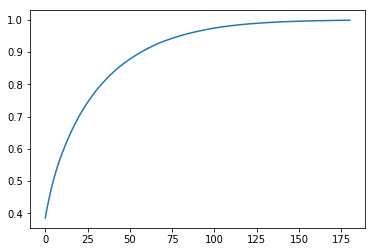

In [58]:
filterNgrams =(ngrams <5)&(dfText >0.80)
pca = PCA(0.999);
pca.fit(np.vstack((known[:,filterNgrams],unknown[:,filterNgrams])));
plt.plot(pca.explained_variance_ratio_.cumsum())

exclusion  = ('fuzzyyule','keselj','manhattan','jaccard','euclidean','stamatatos','chebyshev','yule');

medidas = calcMedidas(known[:,filterNgrams], unknown[:,filterNgrams]);
medidasPCA = calcMedidas(pca.transform(known[:,filterNgrams]), pca.transform(unknown[:,filterNgrams]));
medidasPCA = [m for m in medidasPCA if m[0] not in exclusion]
medidas += [(c[0]+'PCA', c[1]) for c in medidasPCA];
medidas = dict(medidas)

medidasTest = calcMedidas(knownTest[:,filterNgrams], unknownTest[:,filterNgrams]);
medidasPCA = calcMedidas(pca.transform(knownTest[:,filterNgrams]), pca.transform(unknownTest[:,filterNgrams]));
medidasPCA = [m for m in medidasPCA if m[0] not in exclusion]
medidasTest += [(c[0]+'PCA', c[1]) for c in medidasPCA];
medidasTest = dict(medidasTest)

# analise descritiva das variáveis criadas

In [59]:
#pd.DataFrame(dict(medidas)).describe(percentiles=[0.01,0.025,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.975,0.99])

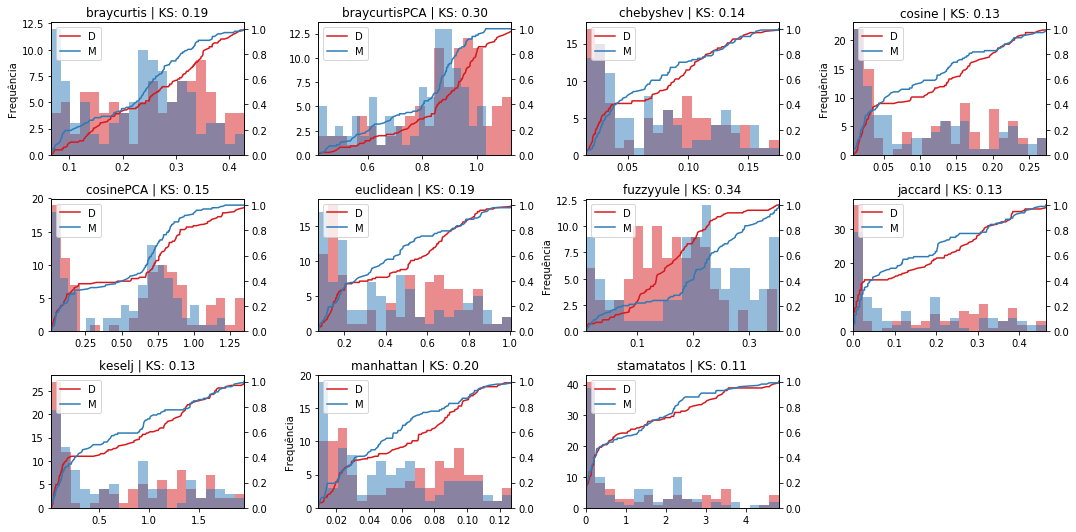

In [60]:
Y = datasetEstudo.answer.values=="Y";
r = math.ceil(math.sqrt(len(medidas)*1.0));
c= math.ceil(len(medidas)/r);
plt.figure(figsize=(15,10*c/r))
for i, d in enumerate(sorted(medidas.keys())):
    #print(d[0])
    plt.subplot(c,r,i+1);
    if i % c == 0:
        plt.ylabel(u"Frequência");
    ks = histKS(medidas[d], Y, cutoff=1, bins=20, labels=['D','M']);
    plt.title("%s | KS: %0.2f" % (d, ks[0]));
plt.tight_layout();
plt.savefig( datasetEstudo.language.unique()[0] + "_KS.png")
plt.show();

In [61]:
Y = datasetEstudo.answer.values=="Y";
KS = pd.DataFrame(
    {'Dissimilaridade':   [m for m in medidas],
    'Kolmogorov-Smirnov': [ks_binary(medidas[m], Y)[0] for m in medidas],
    'Kolmogorov-Smirnov_entropy': [ks_binary(medidas[m], Y)[1] for m in medidas],
    'fClassifDF': np.round([(f_classif(medidas[m].reshape(-1, 1), Y)[1])[0] for m in medidas],3)
    }
);
#KS.plot(kind='bar',x='Dissimilaridade', y='Kolmogorov-Smirnov');
pd.set_option('precision',4)
#KS.to_clipboard(excel=True);
KS.sort_values('Kolmogorov-Smirnov', ascending=False)


,Dissimilaridade,Kolmogorov-Smirnov,Kolmogorov-Smirnov_entropy,fClassifDF
2,fuzzyyule,0.3367,0.4692,0.001
4,braycurtisPCA,0.2959,0.0000,0.001
10,manhattan,0.2041,0.3068,0.129
7,braycurtis,0.1939,0.0320,0.037
8,euclidean,0.1939,0.5508,0.231
6,cosinePCA,0.1531,0.6029,0.310
1,chebyshev,0.1429,0.6927,0.511
9,cosine,0.1327,0.3405,0.235
0,keselj,0.1327,0.6762,0.361
3,jaccard,0.1327,0.6923,0.385


In [62]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=100, random_state=42);
df = pd.DataFrame(medidas)
forest.fit(df, Y);

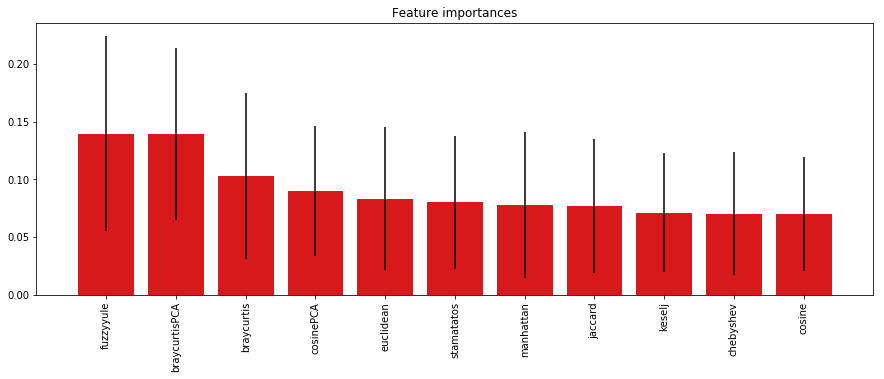

In [63]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
features = df.columns[indices];
# Plot the feature importances of the forest
plt.figure(figsize=(15,5))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices], color="#d7191c", yerr=std[indices], align="center");
plt.xticks(range(len(features)),features,rotation='vertical')
plt.xlim([-1, len(features)])
plt.show()

In [64]:
def plotKSROC(y_pred, y_true):
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1);
    ks =histKS(y_pred, y_true);
    plt.title("Kolmogorov-Simirnov %0.2f | %0.2f | %0.2f" % (ks[0], ks[1], ks[2]))
    plt.subplot(1,2,2);
    fpr, tpr, thresholds = roc_curve(y_score=y_pred,y_true=y_true)
    plt.plot(fpr, tpr, color='darkorange',lw=2, label='ROC curve (area = %0.2f)' % auc(fpr,tpr));
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

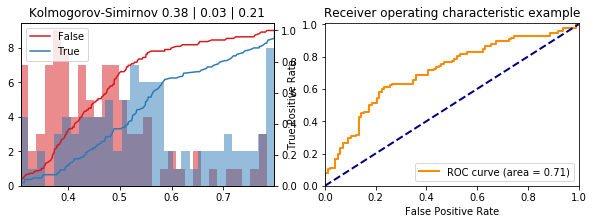

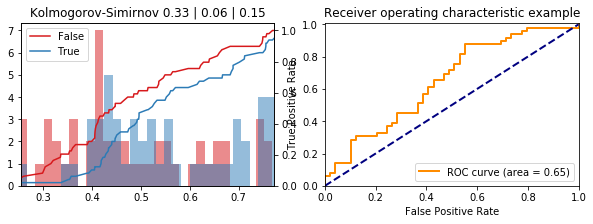

In [65]:
from sklearn.metrics import auc;
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier;
from sklearn.feature_selection import SelectFpr
from sklearn.preprocessing import MinMaxScaler, scale, StandardScaler;
clr = Pipeline([
        #('scaler',StandardScaler()),
        ('scaler',MinMaxScaler()),
        #('pca',PCA(0.99)),
        ('clf1',BaggingClassifier(LogisticRegression(),n_estimators=5)),
])
pred = clr.fit(df, Y).predict_proba(pd.DataFrame(medidasTest))[:,1];
plotKSROC(clr.predict_proba(df)[:,1], Y)
plotKSROC(pred, datasetTest.answer.values == 'Y')

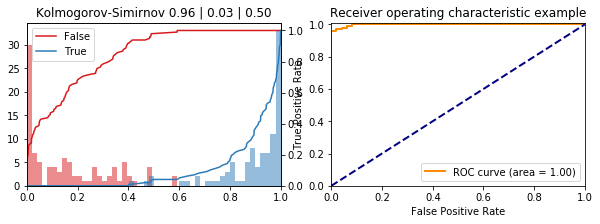

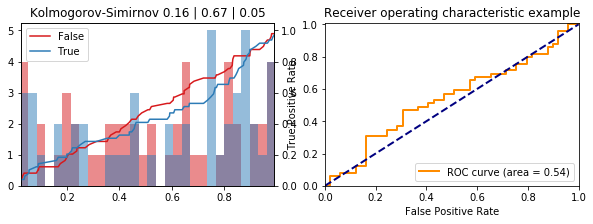

In [52]:
from sklearn.metrics import auc;
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier;
from sklearn.preprocessing import MinMaxScaler, scale;
#pred = forest.predict_proba(pd.DataFrame(medidasTest))[:,1];
#pred = LogisticRegression().fit(df, Y).predict_proba(pd.DataFrame(medidasTest))[:,1];
clr = Pipeline([
        ('scaler',StandardScaler()),
        #('scaler0',MinMaxScaler()),
        ('sel',SelectFpr(alpha=0.9)),
        #('pca',PCA(0.999)),
        ('clf1',BaggingClassifier(LogisticRegression(),n_estimators=5)),
])
def dd(a,b):
    f=(ngrams >2)&(dfText >0.10)
    a = a[:,f];
    b = b[:,f];
    d = np.log(0.01+np.array(np.abs(a-b))**2)
    #d =np.log(0.01+ np.array(np.abs(a-b))**2/np.abs(0.001+a+b))
    return d;
pred = clr.fit(dd(known, unknown), Y).predict_proba(dd(knownTest, unknownTest))[:,1];
plotKSROC(clr.predict_proba(dd(known, unknown))[:,1], Y)
plotKSROC(pred, datasetTest.answer.values == 'Y')

In [53]:
from sklearn.metrics import classification_report;
print(classification_report(y_pred=pred>0.5, y_true=datasetTest.answer.values == 'Y'))


             precision    recall  f1-score   support

      False       0.53      0.47      0.50        49
       True       0.53      0.59      0.56        49

avg / total       0.53      0.53      0.53        98



<Figure size 1080x1080 with 0 Axes>

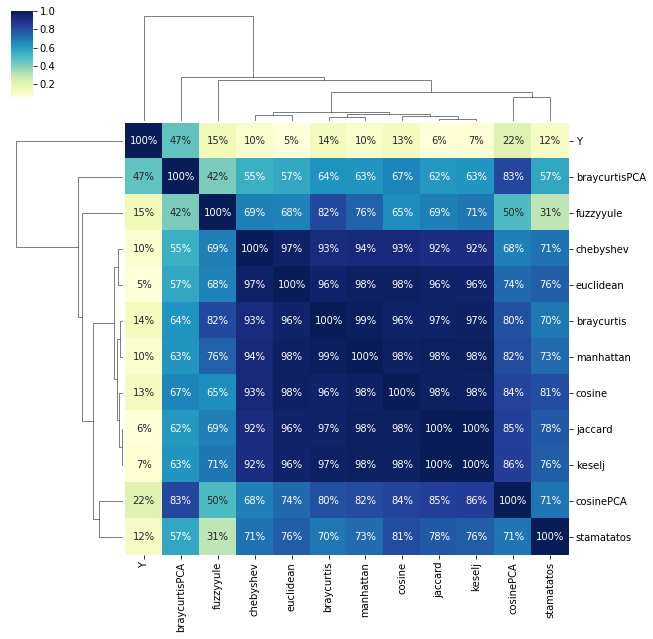

In [54]:
Attr = pd.DataFrame(dict(medidas));
Attr['Y'] = Y;
corr = Attr.corr().abs()
plt.figure(figsize=(15,15));
sns.clustermap(corr,annot=True, cmap="YlGnBu",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
              fmt="0.0%");

In [55]:
def clipping(arr, cutoff):
    a = np.clip(arr, a_min=np.percentile(arr,cutoff), a_max= np.percentile(arr, 100-cutoff))
    return a;

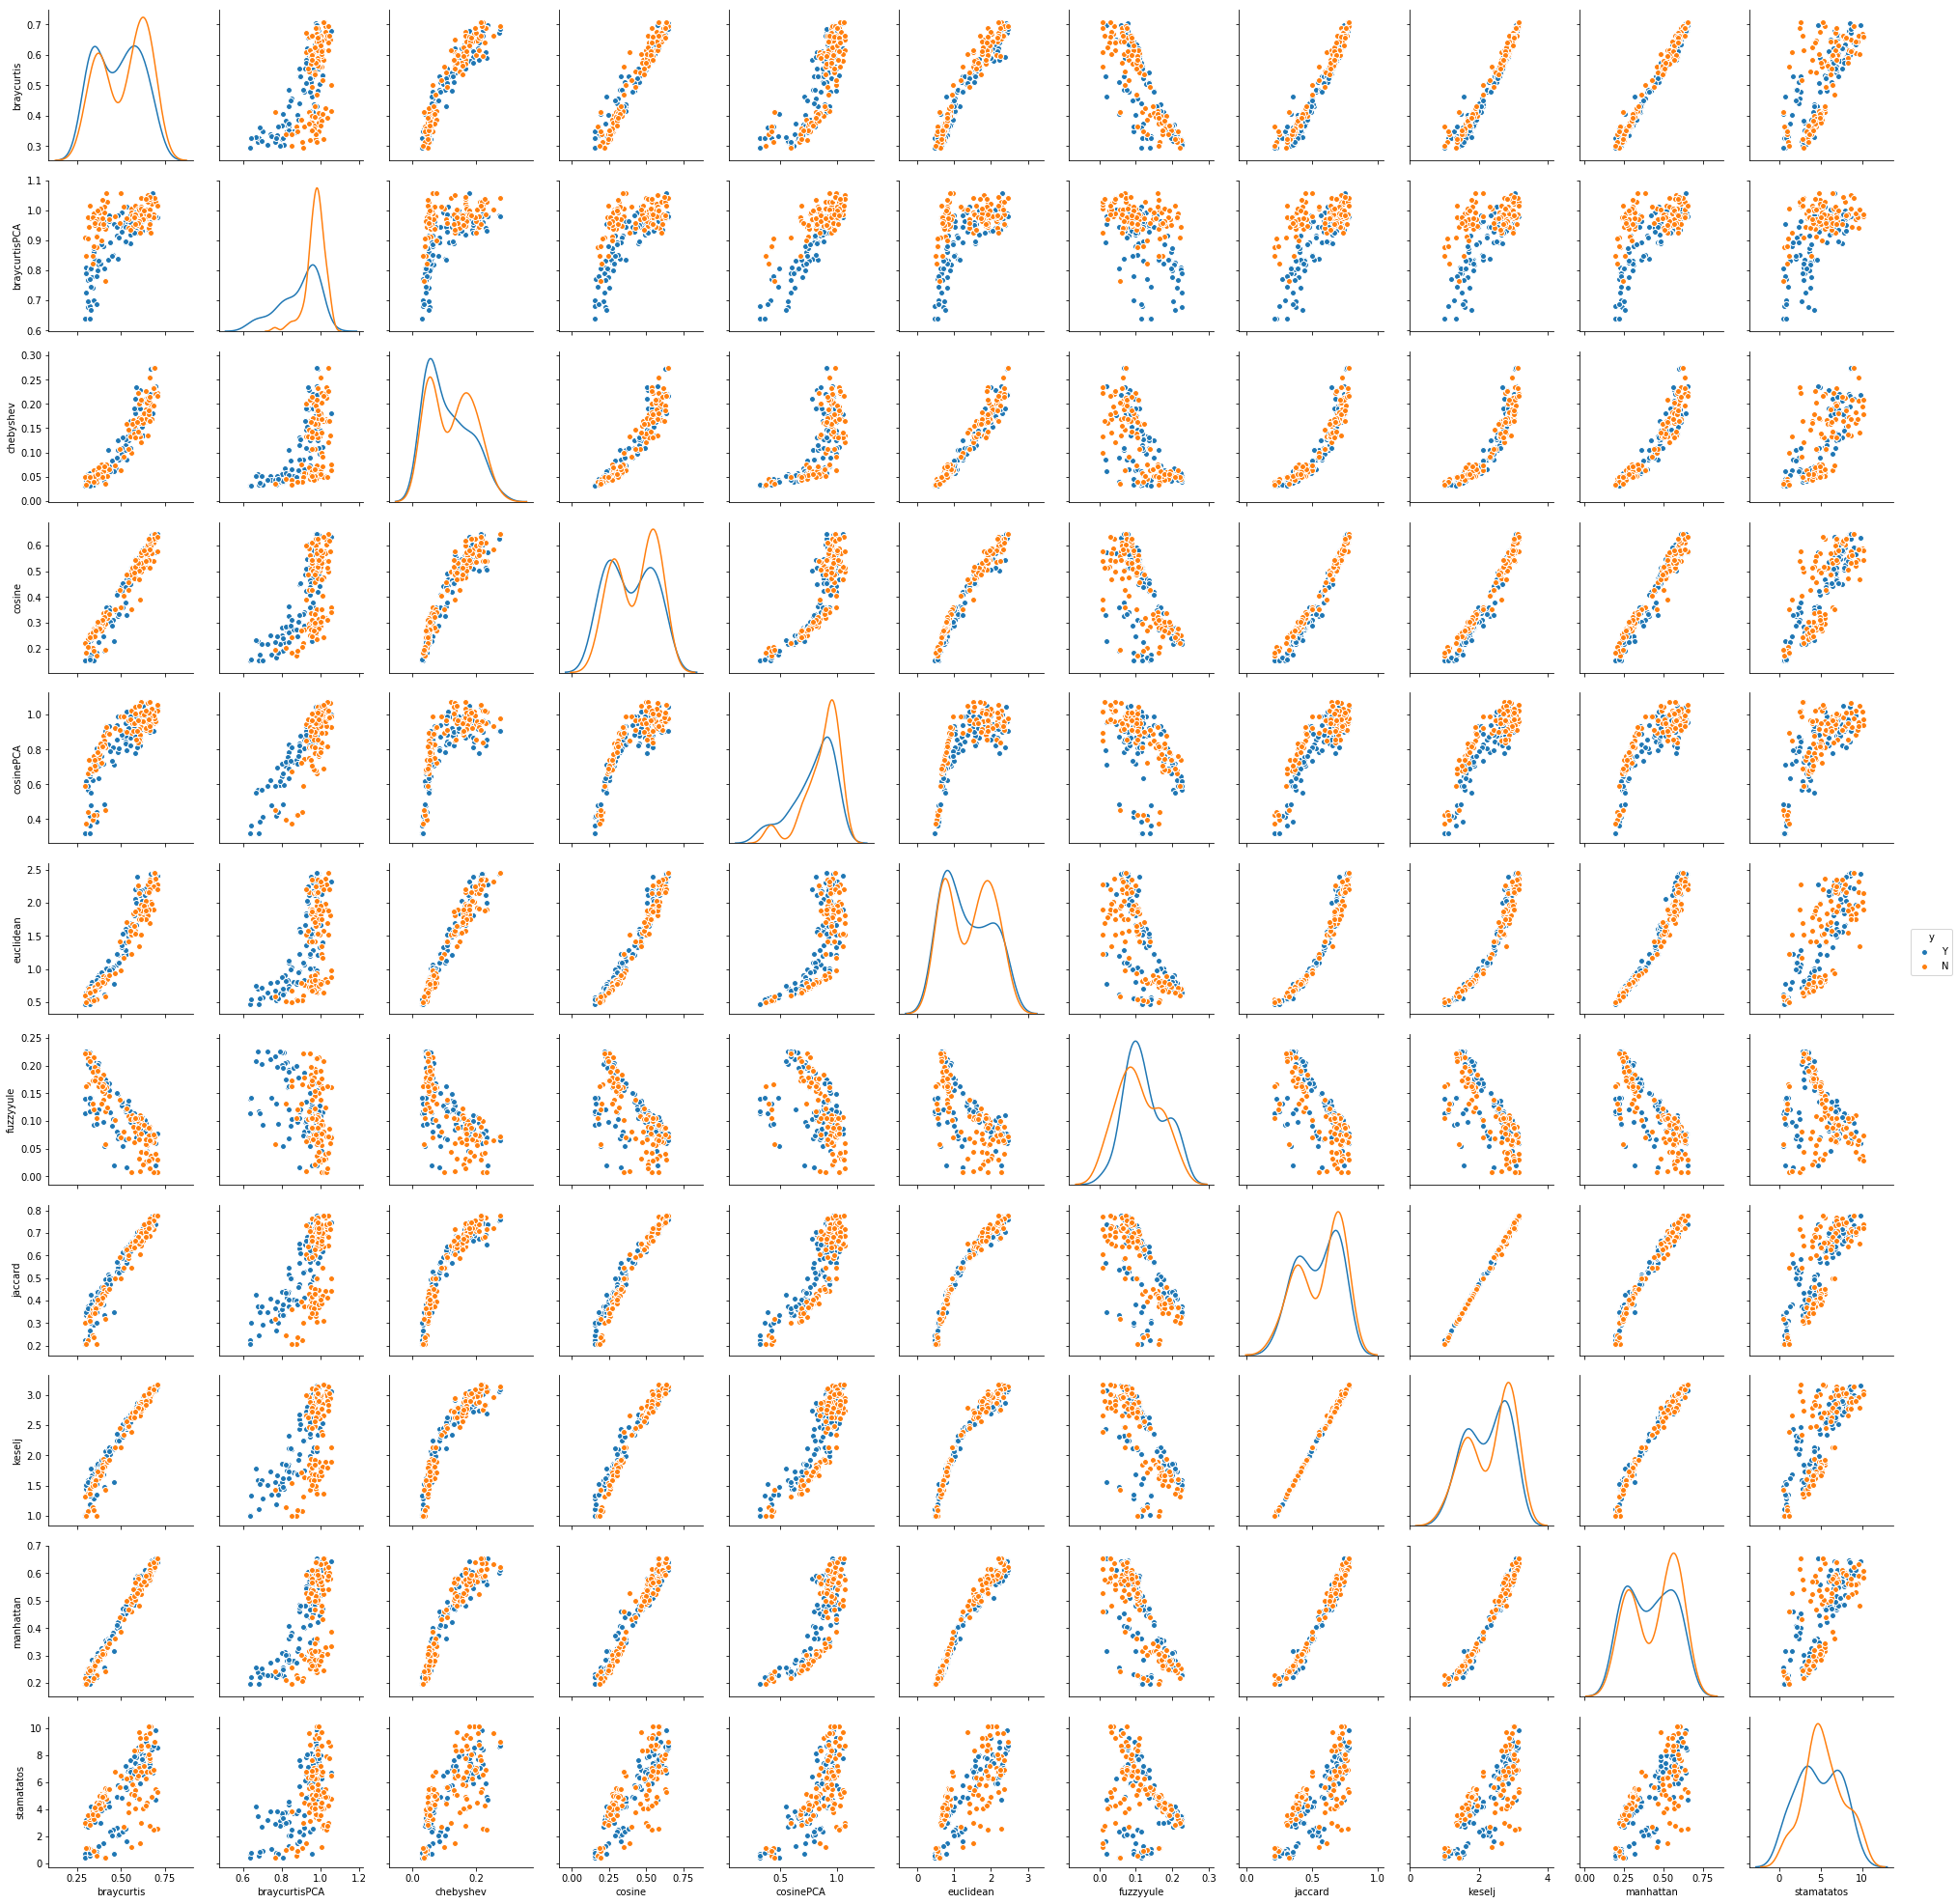

In [56]:
d = pd.DataFrame({m:clipping(medidas[m],1) for m in medidas});
d['y']=datasetEstudo.answer.values
sns.pairplot(d,   hue="y", diag_kind='kde');

In [57]:
d = pd.DataFrame(dict([(m[0],clipping(m[1],1)) for m in medidasPCA])).drop(columns=['stamatatos','keselj','jaccard']);
d['y']=datasetEstudo.answer.values
sns.pairplot(d,   hue="y", diag_kind='kde');

ValueError: labels ['stamatatos' 'keselj' 'jaccard'] not contained in axis

In [ ]:
corr.to_clipboard(excel=True)

In [ ]:
del ma, mb, corr, KS, jaccard, keselj, statamatos, correlation, cosineAB, cosineABpca, known, unknown;

# Classificador utilizando as funções de similiaridade

In [ ]:
XK = datasetEstudo.known.values;
XU = datasetEstudo.unknown.values;
Y = datasetEstudo.answer.values=="Y";

In [ ]:
kf = StratifiedKFold(n_splits=5, random_state =0);

counter = CountVectorizer(
        analyzer="char",
        min_df=0.90,
        max_df=1.0,
        ngram_range=(2,5),
        lowercase=False,
        dtype=np.float32
    );

pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('pca', PCA()),
    ('clf', LogisticRegression(random_state = 0)) 
]);

pipeline2 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression(random_state = 0)) 
]);

In [ ]:
modelsResults = [];

i =0;

for train_index, test_index in kf.split(XK, Y):
    i=i+1;
    print("\niniciando iteração %d" % i);
    
    XKtrain, XKtest = XK[train_index], XK[test_index];
    XUtrain, XUtest = XU[train_index], XU[test_index];
    YTrain , YTest  = Y[train_index] , Y[test_index];
    
    print("Vectorizing known and unknown texts");
    counter.fit(np.append(XKtrain,XUtrain));
    XKtrain, XKtest = counter.transform(XKtrain).todense(), counter.transform(XKtest).todense();
    XUtrain, XUtest = counter.transform(XUtrain).todense(), counter.transform(XUtest).todense();
    
    XKtrain, XKtest  = normalizer(XKtrain), normalizer(XKtest);
    XUtrain, XUtest  = normalizer(XUtrain), normalizer(XUtest);    
    
    
    print("transforming counts into distances - training");  
    pca = PCA();
    pca.fit(np.vstack((XKtrain,XUtrain)));
    variance = pca.explained_variance_ratio_.cumsum();
    cutoff = len(variance[variance<=0.95]);
    if cutoff < 1:
        cutoff = int(XKtrain.shape[1] *0.9);

    pca = PCA(cutoff);    
    pca.fit(np.vstack((XKtrain,XUtrain)));
    
    cosineABtrain    = paired_distances(XKtrain, XUtrain, metric='cosine');
    cosineABpcatrain = paired_distances(pca.transform(XKtrain), pca.transform(XUtrain), metric='cosine');    
    Statamatostrain  = CNG_Stamatatos(XKtrain, XUtrain);
    keseljtrain      = CNG_Keselj(XKtrain, XUtrain);
    jaccardtrain     = paired_distances(XKtrain>0, XUtrain>0, metric=sdistance.jaccard);
    
    Xtrain = np.vstack((cosineABtrain, cosineABpcatrain , Statamatostrain, keseljtrain, jaccardtrain)).T;
    
    print("transforming counts into distances - test");
    cosineABtest     = paired_distances(XKtest, XUtest, metric='cosine');
    cosineABpcatest  = paired_distances(pca.transform(XKtest), pca.transform(XUtest), metric='cosine');   
    Statamatostest   = CNG_Stamatatos(XKtest, XUtest);
    keseljtest       = CNG_Keselj(XKtest, XUtest);
    jaccardtest      = paired_distances(XKtest>0, XUtest>0, metric=sdistance.jaccard);
    
    Xtest = np.vstack((cosineABtest, cosineABpcatest , Statamatostest, keseljtest, jaccardtest)).T;
    
    modesl = ['cosineAB', 'cosinePCA', 'Stamatatos','keselj','jaccard'];
    for j in range(Xtrain.shape[1]):
            print("modelo  vars:",modesl[j]);
            pipeline2.fit(Xtrain[:,j].reshape(-1,1),YTrain);
            predTrain = pipeline2.predict_proba(Xtrain[:,j].reshape(-1,1));
            predTest = pipeline2.predict_proba(Xtest[:,j].reshape(-1,1));

            modelsResults.append({        
                'kfold'     : i,
                'model'     :modesl[j],
                'train': roc_auc_score(YTrain, predTrain[:,1]),
                'test' : roc_auc_score(YTest, predTest[:,1]),
                'ctrain': cScore(YTrain, predTrain[:,1]),
                'ctest' : cScore(YTest, predTest[:,1]),
                'kstrain': ksCurve(YTrain, predTrain[:,1]),
                'kstest' : ksCurve(YTest, predTest[:,1])
            })  ;
    
    print("modelo  mix");
    Xtrain = np.vstack((cosineABtrain, cosineABpcatrain , Statamatostrain)).T;
    Xtest  = np.vstack((cosineABtest, cosineABpcatest , Statamatostest)).T;
    pipeline.fit(Xtrain,YTrain);
    predTrain = pipeline.predict_proba(Xtrain);
    predTest = pipeline.predict_proba(Xtest);
    
    modelsResults.append({        
        'kfold'     : i,
        'model'     :'mix',
        'train': roc_auc_score(YTrain, predTrain[:,1]),
        'test' : roc_auc_score(YTest, predTest[:,1]),
        'ctrain': cScore(YTrain, predTrain[:,1]),
        'ctest' : cScore(YTest, predTest[:,1]),
        'kstrain': ksCurve(YTrain, predTrain[:,1]),
        'kstest' : ksCurve(YTest, predTest[:,1])
    })  ;
    
    print("modelo CNG distancia 1");
    Xtrain = dist(XKtrain,XUtrain);
    Xtest = dist(XKtest,XUtest);
    
    pipeline.fit(Xtrain,YTrain);
    predTrain = pipeline.predict_proba(Xtrain);
    predTest = pipeline.predict_proba(Xtest);
    
    modelsResults.append({        
        'kfold'     : i,
        'model'     :'distancia 1',
        'train': roc_auc_score(YTrain, predTrain[:,1]),
        'test' : roc_auc_score(YTest, predTest[:,1]),
        'ctrain': cScore(YTrain, predTrain[:,1]),
        'ctest' : cScore(YTest, predTest[:,1]),
        'kstrain': ksCurve(YTrain, predTrain[:,1]),
        'kstest' : ksCurve(YTest, predTest[:,1])
    });
    
    print("modelo CNG distancia 2");
    Xtrain = difchi2(XKtrain,XUtrain);
    Xtest = difchi2(XKtest,XUtest);
    
    pipeline.fit(Xtrain,YTrain);
    predTrain = pipeline.predict_proba(Xtrain);
    predTest = pipeline.predict_proba(Xtest);
    
    modelsResults.append({        
        'kfold'     : i,
        'model'     :'distancia 2',
        'train': roc_auc_score(YTrain, predTrain[:,1]),
        'test' : roc_auc_score(YTest, predTest[:,1]),
        'ctrain': cScore(YTrain, predTrain[:,1]),
        'ctest' : cScore(YTest, predTest[:,1]),
        'kstrain': ksCurve(YTrain, predTrain[:,1]),
        'kstest' : ksCurve(YTest, predTest[:,1])
    });

In [ ]:
df = pd.DataFrame(modelsResults).groupby(by=['model']).mean();
pd.DataFrame(modelsResults).groupby(by=['model']).mean()